This notebook contains the preparation of data (0), the modelling of the data (1), and visualisations of the results (2).

#### 0. Prepare the data

##### a) Load the daset that contains the UN GD speeches.

In [3]:
import os
import numpy as np
import pandas as pd

sessions = np.arange(25, 76)
data = []

for session in sessions:
    directory = "data/TXT/Session " + str(session) + " - " + str(1945 + session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0] == ".": #ignore hidden files
            continue
        splt = filename.split("_")
        # Start from 1995
        if session < 50:
            continue
        data.append([session, 1945 + session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_speech.head() # Shape: (4913, 4)

,Session,Year,ISO-alpha3 Code,Speech
0,50,1995,BDI,The United Nations is celebrating its fiftieth...
1,50,1995,VNM,"Allow me at the outset, on behalf of the\ndele..."
2,50,1995,PAK,"I extend to you, Sir, my\ndelegation’s felicit..."
3,50,1995,MLI,We\nare meeting on the eve of the fiftieth ann...
4,50,1995,FRA,"Mr. President, I should like to say first how\..."


Also, load the most recent speeches. Source: https://gadebate.un.org/generaldebate76/en/

In [4]:
# Load recent speeches
from pdfminer.high_level import extract_text

folder = f'data/PDF/Session_76 - 2022/'
data = []

for file in os.listdir(folder):
    if file.startswith('.'):
        continue
    f = open(os.path.join(folder, file), "rb")
    splt = file.split("_")
    data.append([76, 2022, splt[0], extract_text(f)])

df_recent = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech = pd.concat([df_speech, df_recent]) # Shape: (4923, 4)

Dataset now consists of 4923 rows and 4 columns.

##### b) Load the dataset containing the expenses

Downloaded from https://ec.europa.eu/eurostat/databrowser/view/GOV_10A_EXP__custom_3484912/default/table?lang=en

In [5]:
# Load COFOG
cofog = pd.read_csv("data/gov_10a_exp__custom_3484912_page_tabular.tsv", sep='\t')

cofog.iloc[:,0] = cofog.iloc[:,0].str.split(',').str[-1]
cofog.rename(columns={cofog.columns[0]: "ISO-alpha2 Code"}, inplace=True)

# Perform some preprocessing
cofog = cofog.melt(id_vars=["ISO-alpha2 Code"], var_name="Year", value_name='Expenses') # Transpose
cofog['Year'] = cofog['Year'].astype(int) # Typecasting
cofog.loc[:,'Expenses'] = cofog.loc[:,'Expenses'].replace(': ', np.nan) # Replace EL with GR to align with ISO
cofog.dropna(how='any', inplace=True)
cofog['Expenses'] = cofog['Expenses'].astype(str).str.strip().str.extract(r'(\d+.\d+)').astype('float')
cofog.loc[:,'ISO-alpha2 Code'] = cofog.loc[:,'ISO-alpha2 Code'].replace('EL', 'GR') # Replace EL with GR to align with ISO

cofog.head() #Shape (829, 3)

,ISO-alpha2 Code,Year,Expenses
0,AT,1995,55.8
1,BE,1995,52.6
2,BG,1995,31.7
3,CH,1995,33.3
4,CY,1995,30.9


COFOG contains ISO-alpha2 Code while `df_speeches` has ISO-alpha3 codes. We can use the provided `UNSD Methodology` that contains both of these.

##### c) Load dataset containing all names of countries and codes

In [6]:
df_codes = pd.read_csv("data/UNSD — Methodology.csv", delimiter=';')

df_un_merged = cofog.merge(df_codes, how='inner') # DF goes from 832 -> 780, some codes not align
df_un_merged = df_un_merged[["ISO-alpha3 Code", "ISO-alpha2 Code", "Expenses", "Country or Area", "Year", "Region Name", "Sub-region Name"]]

df_un_merged.head() # Schape (780, 7)

,ISO-alpha3 Code,ISO-alpha2 Code,Expenses,Country or Area,Year,Region Name,Sub-region Name
0,AUT,AT,55.8,Austria,1995,Europe,Western Europe
1,AUT,AT,55.6,Austria,1996,Europe,Western Europe
2,AUT,AT,52.3,Austria,1997,Europe,Western Europe
3,AUT,AT,52.2,Austria,1998,Europe,Western Europe
4,AUT,AT,52.1,Austria,1999,Europe,Western Europe


Dataset contains 780 rows and 7 features.

##### e) Merge datasets
Now we have a COFOG dataframe and a speeches which can be merged with the corresponding `ISO-alpha3` codes and the specific year. We also remove non-European countries.

In [7]:
df_final = df_speech.merge(df_un_merged, how='inner', on=['Year', 'ISO-alpha3 Code'])
df_final.head()

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe
3,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe
4,50,1995,GRC,Allow me at the outset\nto extend to the Presi...,GR,46.0,Greece,Europe,Southern Europe


##### f) Clean the `Speech` column

In the cleaning, the speeches are tokenized and stopwords and interpunction are removed.

In [8]:
# Copy speech to new column 'Text"
df_final['Text'] = df_final.loc[:,'Speech'].copy()

In [9]:
from nltk import word_tokenize
from nltk.corpus import stopwords

def preprocess(words):
    """
    Input: List of (tokenized) words
    Return: List of (tokenized) words without stopwords and interpunction
    """
    sw = stopwords.words("english")
    clean = []
    for w in words:
        w = str.lower(w)
        if (w.isalpha()) and (w not in sw):
            clean.append(w)

    return clean

# ! Warning, cell takes longer: about 40 seconds
df_final.loc[:,'Text'] = df_final.loc[:,'Text'].apply(word_tokenize)
df_final.loc[:,'Text'] = df_final.loc[:,'Text'].apply(preprocess)

df_final['Text'].values[4][0:10]

['allow',
 'outset',
 'extend',
 'president',
 'general',
 'assembly',
 'warmest',
 'congratulations',
 'greek',
 'government']

##### h) Quantify the 'attention for the topic of climate change' by the Member States.

Approach: 
1. We use a labeled dataset which is based on this paper
https://arxiv.org/abs/2012.00614.downloaded and is downloaded from https://www.sustainablefinance.uzh.ch/en/research/climate-fever.html.
2. We will drop the claims that didn't have enough evidence.  
3. We collect the words from the `evidence_id` (which is in the `evidences` column): example: ['carbon', 'dioxide']
4. We clean the list: make lowercase, tokenize, remove interpunction.
5. We manually create a list to remove a small set of words that are not climate related and skew the results.
6. We compare the list climate-related words to the words in the speeches and count the occurences.

In [10]:
# 1. Loading the labeled dataset
climate = pd.read_json('data/climate-fever-dataset-r1.jsonl', lines=True) 

# 2. Retrieve the values and remove the uncertain/disputed ones
climate = climate[(climate.claim_label != 'DISPUTED') & (climate.claim_label != 'NOT_ENOUGH_INFO')]

climate.head()

,claim_id,claim,claim_label,evidences
0,0,Global warming is driving polar bears toward e...,SUPPORTS,[{'evidence_id': 'Extinction risk from global ...
1,5,The sun has gone into ‘lockdown’ which could c...,SUPPORTS,"[{'evidence_id': 'Famine:386', 'evidence_label..."
2,6,The polar bear population has been growing.,REFUTES,"[{'evidence_id': 'Polar bear:1332', 'evidence_..."
3,9,Ironic' study finds more CO2 has slightly cool...,REFUTES,"[{'evidence_id': 'Atmosphere of Mars:131', 'ev..."
4,10,Human additions of CO2 are in the margin of er...,REFUTES,[{'evidence_id': 'Carbon dioxide in Earth's at...


In [51]:
# 3. Extract evidences/evidence 
evidences = [i for i in climate.claim.values]

# res = []
# for i in evidences:
#     evi = dict(i[0])
#     for key, value in evi.items():
#         if key == 'evidence_id':
#             res.append(value.split(':')[0])

res = ' '.join([i for i in set(evidences)])

In [54]:
# 4. Extract evidences and clean
climate_words = word_tokenize(res)
climate_words = preprocess(climate_words)

frequent_words = ['anyone', 'new','jersey','protocol','scholar','google','election', 'general', 'united', 'nations', 'france', 'election','european', 'state', 'government', 'agreement', 'great', 'el', 'since']

climate_words = [word for word in climate_words if word not in frequent_words]

print(len(climate_words)) # ~10.000 climate related words

10091


In [55]:
with open('climate_words.txt', 'w') as f:
    for i in climate_words:
        f.write(i)
        f.write("\n") # To see the words

5. Count the occurences of climate related words in the speeches 

In [56]:
def count_occurrences(words):
    counts = {}
    count = 0
    for word in climate_words:
        if (word in words):
            if word in counts.keys():
                counts[word] += 1
            else:
                counts[word] = 1
    total = sum(counts.values())
    return total

# Warning, cell takes long: over 1m
df_final['Count'] = df_final['Text'].apply(count_occurrences)

In [57]:
df_final['Count'][:10].values

array([2616, 2915, 1914, 1859, 2628, 2544, 2952, 1884, 2329, 2007])

In [59]:
df_final.head()

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name,Text,Count,Decade
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe,"[president, like, say, first, pleased, france,...",2616,2000
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe,"[warmly, congratulate, president, election, pr...",2915,2000
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe,"[today, ever, realize, delegations, many, coun...",1914,2000
3,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe,"[may, extend, congratulations, sir, upon, elec...",1859,2000
4,50,1995,GRC,Allow me at the outset\nto extend to the Presi...,GR,46.0,Greece,Europe,Southern Europe,"[allow, outset, extend, president, general, as...",2628,2000


##### h) Exploration phase

##### 1. Some general stats

In [60]:
wc_years = np.mean(df_final.Count.values) # Mean word count over the years
max_years = np.max(df_final.Count.values) # Max word count over the years
min_years = np.min(df_final.Count.values) # Max word count over the years

print(f"Mean climate related word count between 1995 and 2022: \t {wc_years}")
print(f"Highest climate related word count between 1995 and 2022: \t {max_years}")
print(f"Lowest climate related word count between 1995 and 2022: \t {min_years}")

Mean climate related word count between 1995 and 2022: 	 1937.8647594278284
Highest climate related word count between 1995 and 2022: 	 3811
Lowest climate related word count between 1995 and 2022: 	 682


In [61]:
GDP_years = np.mean(df_final.Expenses.values) # Mean GDP over the years
max_GDP = np.max(df_final.Expenses.values) # Highest GDP % to environmental protection over the years
min_GDP = np.min(df_final.Expenses.values) # Lowest GDP % to environmental protection over the years

print(GDP_years); print(max_GDP); print(min_GDP)

44.87607282184655
64.9
24.2


In [62]:
# Might come in handy
df_final['Decade'] = df_final['Year'].apply(lambda i: round(i, -1))

##### 2. All EU countries together: expenses and climate change related mean word count mean, grouped by year

In [64]:
grouped = df_final.groupby(['Year'], as_index=False, sort=False).agg(
    {'Expenses': 'mean', 'Count': 'mean'}
    )

grouped.head()

,Year,Expenses,Count
0,1995,47.389286,2051.321429
1,1996,46.328571,2017.928571
2,1997,45.353571,2021.678571
3,1998,44.803448,2047.379310
4,1999,45.137931,1985.862069


In [65]:
print(grouped[grouped['Count'] == min(grouped['Count'])])
print(grouped[grouped['Count'] == max(grouped['Count'])]) 
print(np.mean(grouped['Count']))

   Year  Expenses   Count
7  2002      44.0  1586.9
    Year  Expenses   Count
24  2019     42.92  2353.6
1938.8539282556524


In [66]:
print(grouped[grouped['Expenses'] == min(grouped['Expenses'])])
print(grouped[grouped['Expenses'] == max(grouped['Expenses'])])
print(np.mean(grouped['Expenses']))

    Year   Expenses   Count
12  2007  42.163333  2023.8
    Year   Expenses        Count
25  2020  49.517241  2077.034483
44.891239737274226


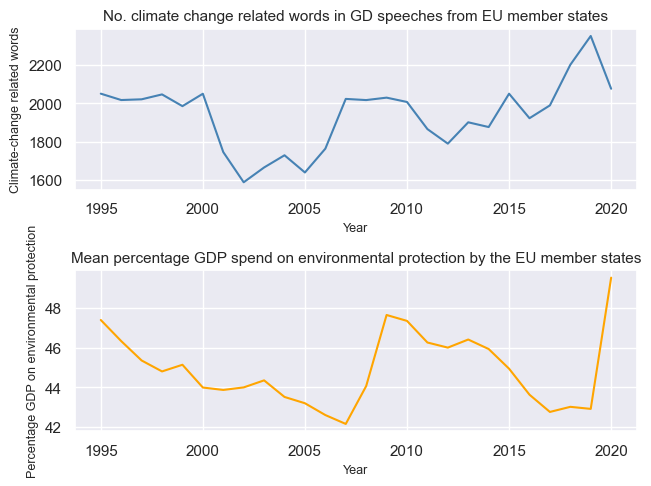

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set styling parameters for sns
sns.set_theme(); sns.set_context('notebook'); sns.set_style('darkgrid')

X = grouped['Year'].values
y1 = grouped['Count'].values
y2 = grouped['Expenses'].values

fig, ax = plt.subplots(2,1)

sns.lineplot(x=X, y=y1, color="steelblue", ax=ax[0])
sns.lineplot(x=X, y=y2, color="orange", ax=ax[1])

ax[0].set_xlabel("Year", fontsize=9) 
ax[0].set_ylabel("Climate-change related words", fontsize=9)
ax[0].set_title("No. climate change related words in GD speeches from EU member states",fontsize=11)

ax[1].set_xlabel("Year", fontsize=9) 
ax[1].set_ylabel("Percentage GDP on environmental protection", fontsize=9)
ax[1].set_title("Mean percentage GDP spend on environmental protection by the EU member states", fontsize=11)

fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

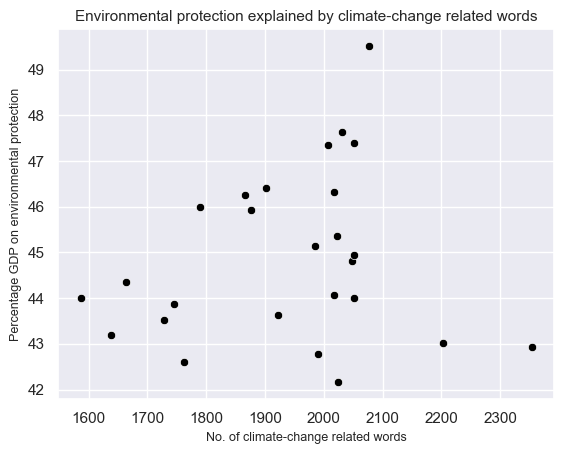

In [68]:
fig, ax = plt.subplots()

sns.scatterplot(x=y1, y=y2, color='black', ax=ax) # Explanatory: WC # Response: Expenses

ax.set_xlabel("No. of climate-change related words", fontsize=9) 
ax.set_ylabel("Percentage GDP on environmental protection", fontsize=9)
ax.set_title("Environmental protection explained by climate-change related words", fontsize=11)

plt.show()

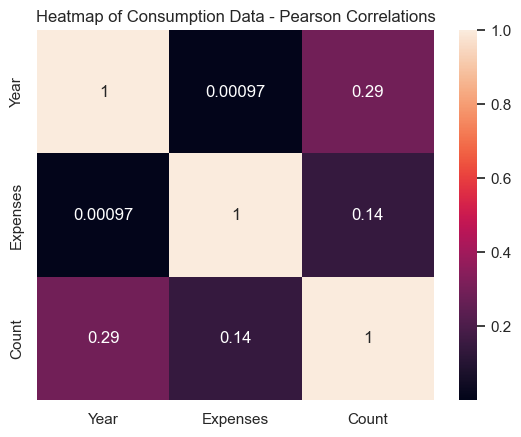

In [69]:
sns.heatmap(grouped.corr(), annot=True).set(title='Heatmap of Consumption Data - Pearson Correlations');

In [70]:
grouped.describe()

,Year,Expenses,Count
count,26.000000,26.000000,26.000000
mean,2007.500000,44.891240,1938.853928
std,7.648529,1.838288,177.803259
min,1995.000000,42.163333,1586.900000
25%,2001.250000,43.548333,1808.425000
50%,2007.500000,44.578391,1998.766667
75%,2013.750000,46.192500,2043.142816
max,2020.000000,49.517241,2353.600000


##### 3. EU countries grouped by sub-region and interested in expenses and climate change related word count mean

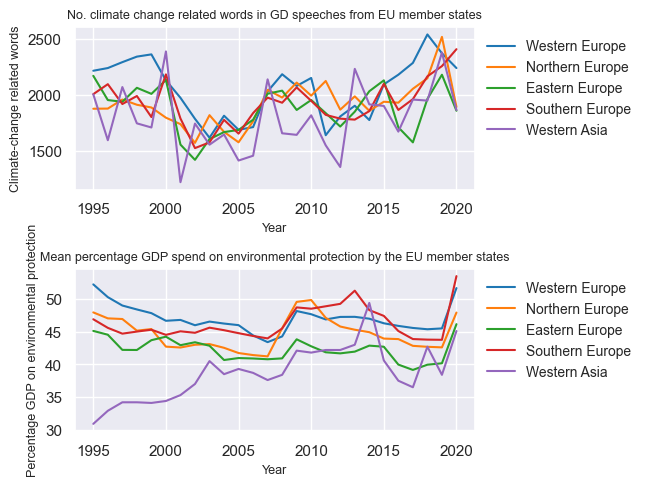

In [71]:
# Climate related word count for regions (in EU)
regions = df_final.groupby(['Year', 'Sub-region Name'], as_index=False, sort=False)[['Expenses', 'Count']].mean()

X = regions['Year'].values
y1 = regions['Count'].values
y2 = regions['Expenses'].values

fig, ax = plt.subplots(2,1)

sns.lineplot(x="Year", y="Count", hue='Sub-region Name', data=regions, palette='tab10', ax=ax[0])
sns.lineplot(x="Year", y="Expenses", hue='Sub-region Name', data=regions, palette='tab10', ax=ax[1])


ax[0].set_xlabel("Year", fontsize=9) 
ax[0].set_ylabel("Climate-change related words", fontsize=9)
ax[0].set_title("No. climate change related words in GD speeches from EU member states",fontsize=9)
ax[0].legend(ncol=1, bbox_to_anchor=(1, 1), fontsize='small', frameon=False)

ax[1].set_xlabel("Year", fontsize=9) 
ax[1].set_ylabel("Percentage GDP on environmental protection", fontsize=9)
ax[1].set_title("Mean percentage GDP spend on environmental protection by the EU member states", fontsize=9)
ax[1].legend(ncol=1, bbox_to_anchor=(1, 1), fontsize='small', frameon=False)


fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()


##### 4. All countries seperate expenses and climate change related word count mean

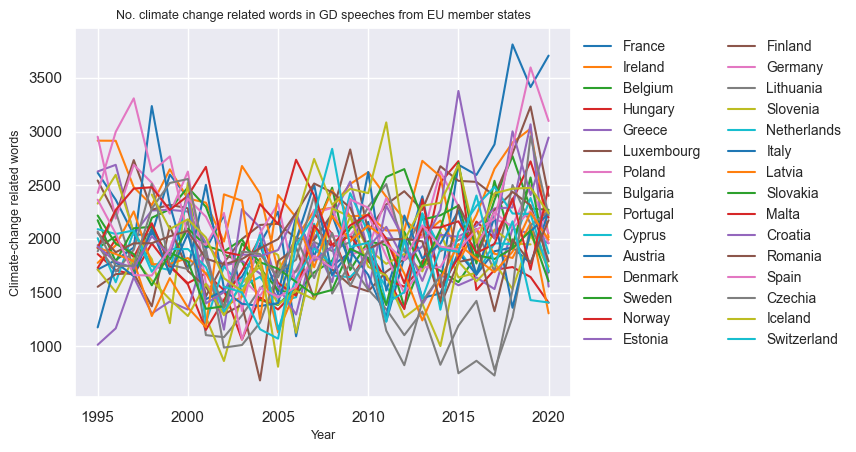

In [72]:
# Climate related word count for countries (in EU)
ax = sns.lineplot(x="Year", y="Count", hue='Country or Area', data=df_final, palette='tab10')

ax.set_xlabel("Year", fontsize=9) 
ax.set_ylabel("Climate-change related words", fontsize=9)
ax.set_title("No. climate change related words in GD speeches from EU member states",fontsize=9)
ax.legend(ncol=2, bbox_to_anchor=(1, 1), fontsize='small', frameon=False)

plt.show()

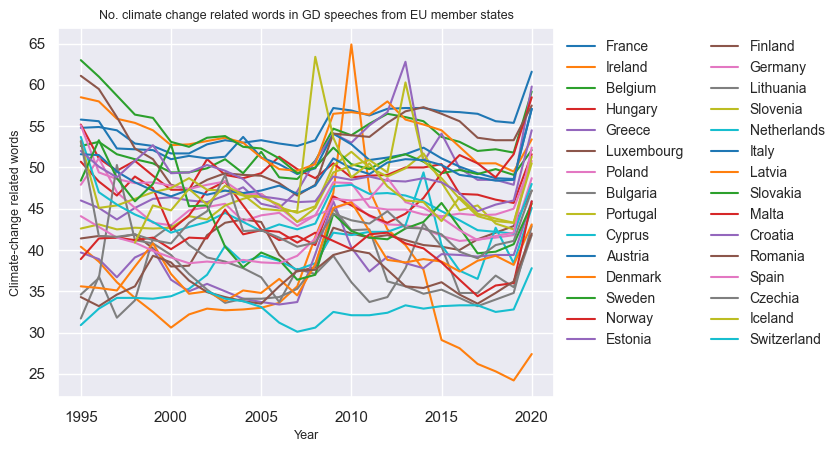

In [73]:
# Climate related word count for countries (in EU)
ax = sns.lineplot(x="Year", y="Expenses", hue='Country or Area', data=df_final, palette='tab10')

ax.set_xlabel("Year", fontsize=9) 
ax.set_ylabel("Climate-change related words", fontsize=9)
ax.set_title("No. climate change related words in GD speeches from EU member states",fontsize=9)
ax.legend(ncol=2, bbox_to_anchor=(1, 1), fontsize='small', frameon=False)

plt.show()

In [74]:
df_final.corr()

/var/folders/w6/wls6h0xj20gfpbn2wgd3pf9w0000gn/T/ipykernel_72517/2875322423.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_final.corr()


,Session,Year,Expenses,Count,Decade
Session,1.000000,1.000000,0.001187,0.119329,0.929998
Year,1.000000,1.000000,0.001187,0.119329,0.929998
Expenses,0.001187,0.001187,1.000000,0.058276,-0.004968
Count,0.119329,0.119329,0.058276,1.000000,0.197203
Decade,0.929998,0.929998,-0.004968,0.197203,1.000000


#### 1. Modelling

##### 1. Single variable linear model on the grouped dataframe (grouped per year, means expenses and count)

In [75]:
grouped = grouped.set_index(grouped.Year.values) # idx = year
df = grouped.copy()

In [144]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = preprocessing.scale(df['Count'].values) #(26,)
y = df['Expenses'].values #(26,)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train
lm_model = LinearRegression(fit_intercept=True)
lm_model.fit(X_train[:, np.newaxis], y_train) # Fit line to our data

print('Intercept:', lm_model.intercept_)
print('Slope:', lm_model.coef_)

# Predict
X_fit = np.linspace(min(X), max(X), len(X_test))
y_pred = lm_model.predict(X_fit[:, np.newaxis])

Intercept: 45.040154528654824
Slope: [0.40001844]


In [146]:
# Evaluate model accuracy
print("Mean squared error - Test: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score - Test: %.2f' % r2_score(y_test, y_pred))

Mean squared error - Test: 4.38
Variance score - Test: -0.65


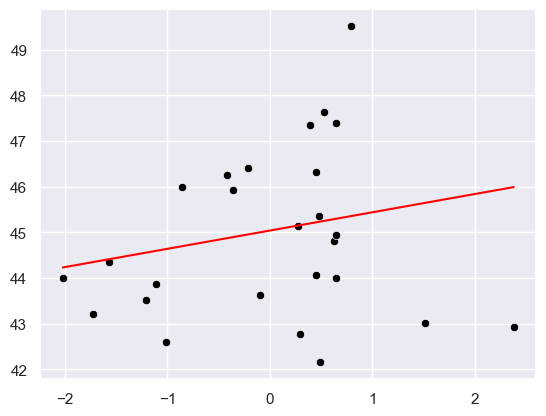

In [147]:
sns.scatterplot(x=X, y=y, c='black')
sns.lineplot(x=X_fit, y=y_pred, c='red')
plt.show()

##### 1.a. Polynomial model on the grouped dataframe (grouped per year, means expenses and count)

In [148]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
polymodel = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept=True))

polymodel.fit(X_train[:, np.newaxis], y_train)

# Test
X_fit = np.linspace(min(X), max(X), len(X_test))
y_pred = polymodel.predict(X_fit[:, np.newaxis])

In [149]:
# Evaluate model accuracy
print("Mean squared error - Test: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score - Test: %.2f' % r2_score(y_test, y_pred))

Mean squared error - Test: 3.37
Variance score - Test: -0.26


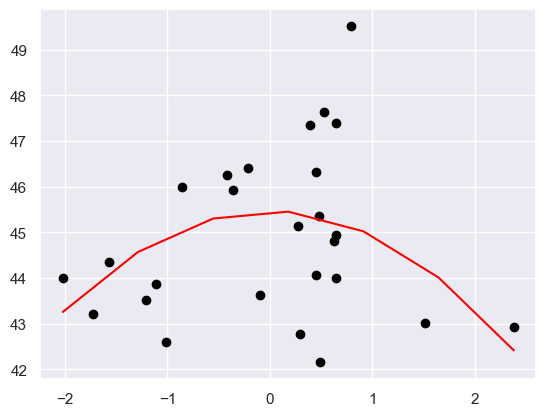

In [150]:
# Plot
fig, ax = plt.subplots()
ax.scatter(X, y, c='black')
ax.plot(X_fit, y_pred, c='red');
plt.show()

##### 2. Preprocessed scale single variable regression model on all countries

In [151]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = preprocessing.scale(df_final['Count'].values)
y = df_final['Expenses'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lm_model = make_pipeline (
    LinearRegression(fit_intercept=True)
)

lm_model.fit(X_train[:, np.newaxis], y_train)

# Eva
X_fit = np.linspace(min(X), max(X), len(X))
y_pred = lm_model.predict(X_fit[:, np.newaxis])

In [129]:
# Evaluate
print("Mean squared error - Test: %.2f" % mean_squared_error(y, y_pred))
print('Variance score - Test: %.2f' % r2_score(y, y_pred))

Mean squared error - Test: 47.79
Variance score - Test: -0.00


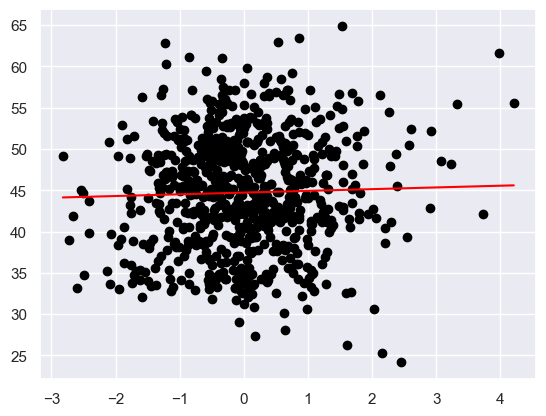

In [130]:
plt.scatter(X, y, c='black')
plt.plot(X_fit, y_pred, c='red')
plt.show()

#### 2.b. Polynomial model on all countries

In [134]:
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
polymodel = make_pipeline(PolynomialFeatures(6), LinearRegression(fit_intercept=True))

polymodel.fit(X_train[:, np.newaxis], y_train)

# Test
X_fit = np.linspace(min(X), max(X), 769)
y_pred = polymodel.predict(X_fit[:, np.newaxis])


In [135]:
# Evaluate
print("Mean squared error - Test: %.2f" % mean_squared_error(y, y_pred))
print('Variance score - Test: %.2f' % r2_score(y, y_pred))

Mean squared error - Test: 68.18
Variance score - Test: -0.43


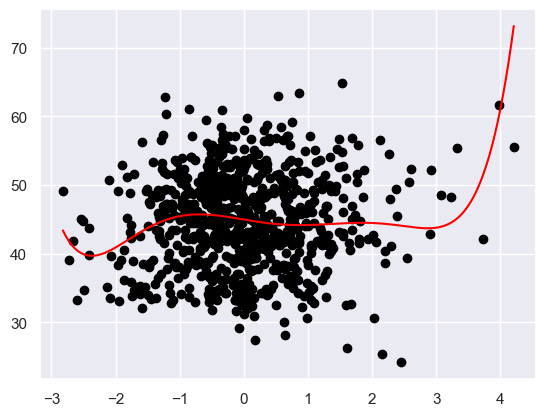

In [136]:
plt.scatter(X, y, c='black')
plt.plot(X_fit, y_pred, c='red') # Best-fit
plt.show()

##### 3 Sub-regions linear

In [166]:
# Climate related word count for regions (in EU)
regions = df_final.groupby(['Year', 'Sub-region Name'], as_index=False, sort=False)[['Expenses', 'Count']].mean()

X = preprocessing.scale(regions['Count'].values) #(26,)
y = regions['Expenses'].values

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train
lm_model = LinearRegression(fit_intercept=True)
lm_model.fit(X_train[:, np.newaxis], y_train) # Fit line to our data

print('Intercept:', lm_model.intercept_)
print('Slope:', lm_model.coef_)

# Predict
X_fit = np.linspace(min(X), max(X), 130)
y_pred = lm_model.predict(X_fit[:, np.newaxis])

Intercept: 44.72201612788706
Slope: [0.20816705]


In [167]:
# Evaluate
print("Mean squared error - Test: %.2f" % mean_squared_error(y, y_pred))
print('Variance score - Test: %.2f' % r2_score(y, y_pred))

Mean squared error - Test: 16.86
Variance score - Test: -0.04


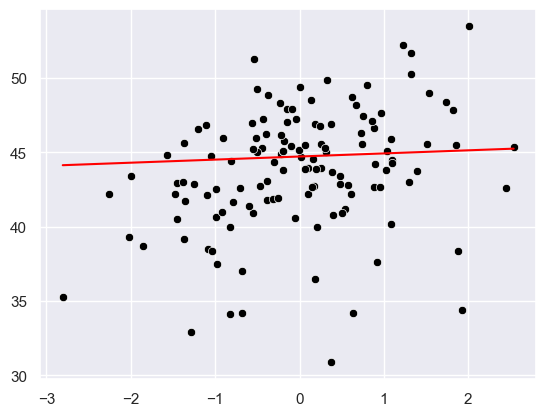

In [168]:
sns.scatterplot(x=X, y=y, c='black')
sns.lineplot(x=X_fit, y=y_pred, c='red')
plt.show()

In [206]:
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
polymodel = make_pipeline(PolynomialFeatures(5), LinearRegression(fit_intercept=True))

polymodel.fit(X_train[:, np.newaxis], y_train)

# Test
X_fit = np.linspace(min(X), max(X), 130)
y_pred = polymodel.predict(X_fit[:, np.newaxis])


In [207]:
# Evaluate
print("Mean squared error - Test: %.2f" % mean_squared_error(y, y_pred))
print('Variance score - Test: %.2f' % r2_score(y, y_pred))

Mean squared error - Test: 21.74
Variance score - Test: -0.34


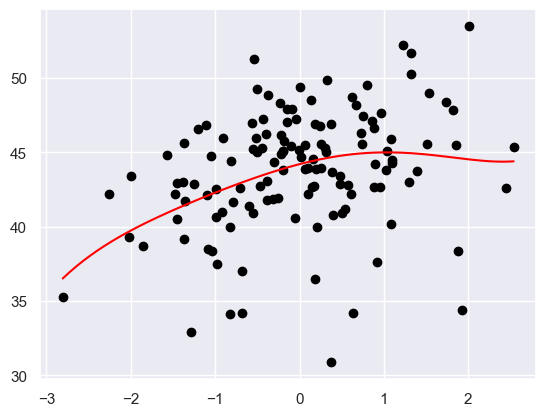

In [208]:
plt.scatter(X, y, c='black')
plt.plot(X_fit, y_pred, c='red') # Best-fit
plt.show()

Conclusion: Very bad.

##### Geopandas

In [46]:
# import geopandas

# world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# europe = world.merge(df_speech, how='inner', left_on='name', right_on='Country or Area')

In [47]:
# ax = world.plot(, color='white', edgecolor='black')
# fig, ax = plt.subplots(1)
# europe.plot(column='Count', ax=ax, legend=True)